### Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')

### Efficiency Distribution

In [3]:
# Update efficient_clients and inefficient_clients with the encoded dataframe
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

total_clients = len(clients)
num_efficient = len(efficient_clients)
num_inefficient = len(inefficient_clients)
pct_efficient = num_efficient / total_clients * 100
pct_inefficient = num_inefficient / total_clients * 100

print(f"Number of efficient clients: {num_efficient} ({pct_efficient:.1f}%)")
print(f"Number of inefficient clients: {num_inefficient} ({pct_inefficient:.1f}%)")


Number of efficient clients: 34273 (81.7%)
Number of inefficient clients: 7677 (18.3%)


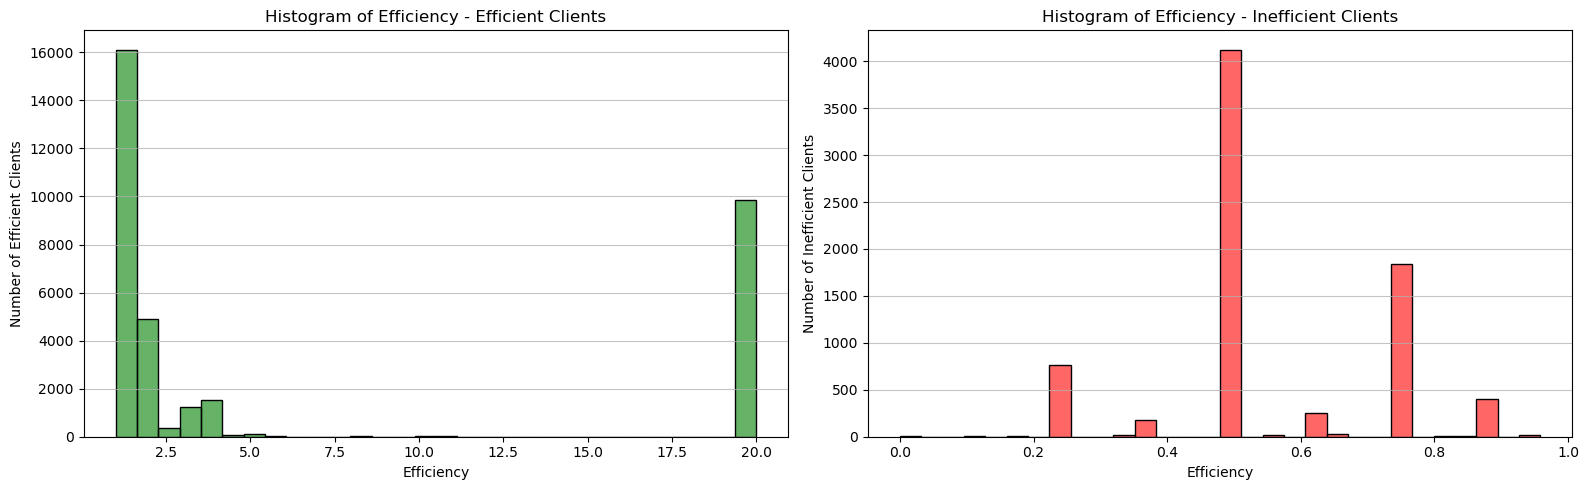

In [4]:
# Plot histograms of efficiency for efficient and inefficient clients side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Efficient Clients
sns.histplot(efficient_clients['efficiency'], bins=30, color='green', edgecolor='black', alpha=0.6, ax=axes[0])
axes[0].set_title('Histogram of Efficiency - Efficient Clients')
axes[0].set_xlabel('Efficiency')
axes[0].set_ylabel('Number of Efficient Clients')
axes[0].grid(axis='y', alpha=0.75)

# Inefficient Clients
sns.histplot(inefficient_clients['efficiency'], bins=30, color='red', edgecolor='black', alpha=0.6, ax=axes[1])
axes[1].set_title('Histogram of Efficiency - Inefficient Clients')
axes[1].set_xlabel('Efficiency')
axes[1].set_ylabel('Number of Inefficient Clients')
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


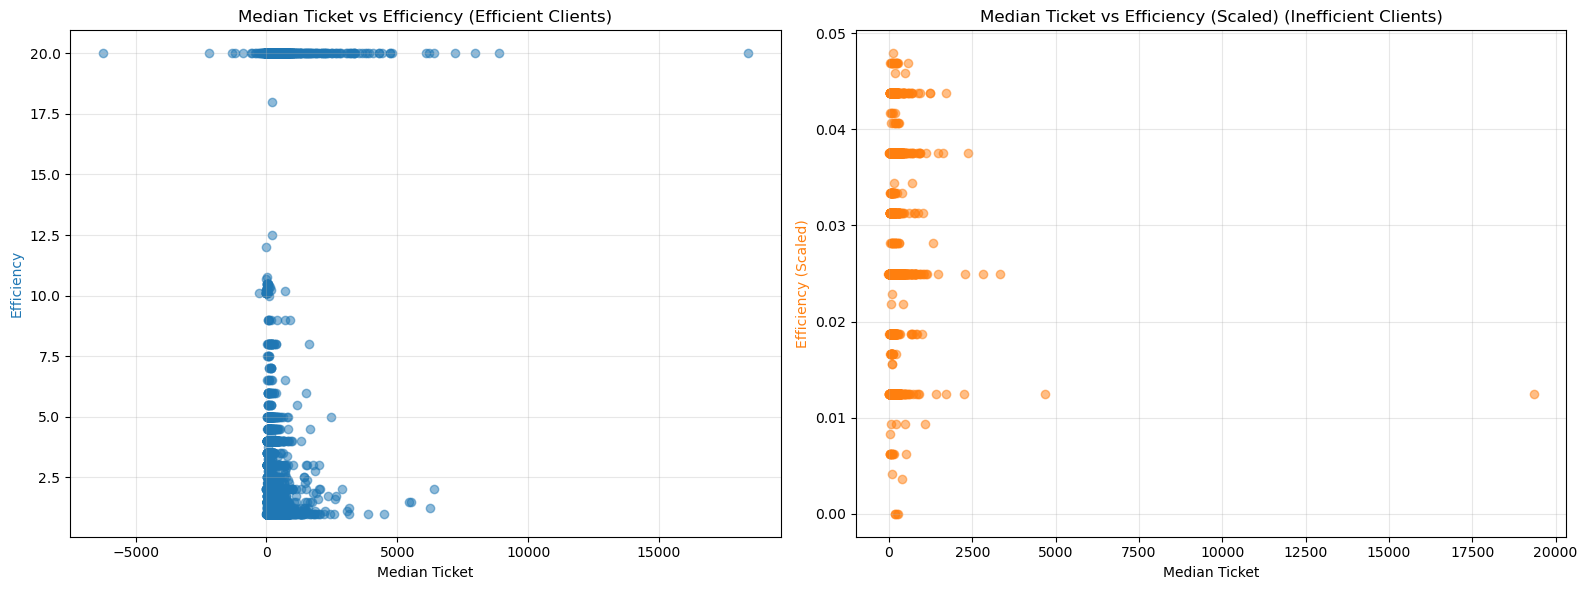

In [5]:
# Plot side by side: Efficiency vs Median Ticket (Efficient) and Efficiency (Scaled) vs Median Ticket (Inefficient)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Efficient clients
axes[0].scatter(efficient_clients['median_ticket'], efficient_clients['efficiency'], alpha=0.5, color='tab:blue', label='Efficiency')
axes[0].set_xlabel('Median Ticket')
axes[0].set_ylabel('Efficiency', color='tab:blue')
axes[0].set_title('Median Ticket vs Efficiency (Efficient Clients)')
axes[0].grid(True, alpha=0.3)

# Right plot: Inefficient clients
axes[1].scatter(inefficient_clients['median_ticket'], inefficient_clients['efficiency_scaled'], alpha=0.5, color='tab:orange', label='Efficiency (Scaled)')
axes[1].set_xlabel('Median Ticket')
axes[1].set_ylabel('Efficiency (Scaled)', color='tab:orange')
axes[1].set_title('Median Ticket vs Efficiency (Scaled) (Inefficient Clients)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Target Variable

In [6]:
clients['optimal_visits_per_month'] = 0
clients['optimal_visits_per_month'] = clients['optimal_visits_per_month'].astype(float)

# For efficient clients (efficiency >= 1), set optimal visits equal to current visits_per_month
clients.loc[clients['efficiency'] >= 1, 'optimal_visits_per_month'] = clients.loc[clients['efficiency'] >= 1, 'median_promotor_visits']

### Hot Encoding

In [7]:
pure_categorical_features = ['promotor_id','city','channel']

# One-hot encode pure categorical features
clients = pd.get_dummies(clients, columns=pure_categorical_features, drop_first=True)
encoded_feature_cols = clients.columns.tolist()

high_corr = ['client_id','promotor_id','city', 'channel','class','efficiency', 'efficiency_scaled', 'median_promotor_visits', 'median_promotor_calls', 'avg_visits_per_month','visit_order_gap','inefficiency_cost','profit_per_visit','opportunity_cost']

# Remove high_corr items from the combined list
selected_features = [f for f in (encoded_feature_cols) if f not in high_corr]

### XGBoost

In [8]:
high_corr = ['client_id','promotor_id','city', 'channel','class','efficiency', 'efficiency_scaled', 'median_promotor_visits', 'median_promotor_calls', 'avg_visits_per_month','visit_order_gap','inefficiency_cost','profit_per_visit','opportunity_cost']

# Remove high_corr items from the combined list
selected_features = [f for f in (encoded_feature_cols) if f not in high_corr]

In [9]:
# !pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features = selected_features

# Update efficient_clients and inefficient_clients with the encoded dataframe
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

efficient_X = efficient_clients[features]
efficient_y = efficient_clients['optimal_visits_per_month']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    efficient_X, efficient_y, test_size=0.2, random_state=42
)

# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regressor MSE (efficient clients, optimal visits): {mse:.4f}")
print(f"XGBoost Regressor R2 (efficient clients, optimal visits): {r2:.4f}")

# Use the trained XGBoost model to predict optimal visits for inefficient clients (efficiency < 1)
inefficient_X = inefficient_clients[features]

# Predict optimal visits per month for inefficient clients
inefficient_clients['predicted_optimal_visits_per_month'] = xgb_reg.predict(inefficient_X)

# Optionally, set a minimum threshold (e.g., 0.5 visits/month) to avoid zero or negative predictions
inefficient_clients['predicted_optimal_visits_per_month'] = inefficient_clients['predicted_optimal_visits_per_month'].clip(lower=0.5)

# Round predicted visits to the nearest whole number
inefficient_clients['predicted_optimal_visits_per_month'] = inefficient_clients['predicted_optimal_visits_per_month'].round().astype(int)

# Create a new efficiency metric: frequency divided by predicted optimal visits
inefficient_clients['new_efficiency'] = inefficient_clients['frequency'] / inefficient_clients['predicted_optimal_visits_per_month']

# Calculate the improvement in efficiency for each client
inefficient_clients['efficiency_improvement'] = inefficient_clients['new_efficiency'] - inefficient_clients['efficiency']

# Optionally, show summary statistics
mean_improvement = inefficient_clients['efficiency_improvement'].mean()
median_improvement = inefficient_clients['efficiency_improvement'].median()
print(f"Mean efficiency improvement (inefficient clients): {mean_improvement:.4f}")
print(f"Median efficiency improvement (inefficient clients): {median_improvement:.4f}")


XGBoost Regressor MSE (efficient clients, optimal visits): 0.0000
XGBoost Regressor R2 (efficient clients, optimal visits): 1.0000
Mean efficiency improvement (inefficient clients): 1.2255
Median efficiency improvement (inefficient clients): 0.7500


Sample of inefficient clients with current number of visits, predicted optimal visits, and efficiency improvement:


,client_id,efficiency,frequency,median_promotor_visits,predicted_optimal_visits_per_month,new_efficiency,efficiency_improvement
2,100042162,0.25,1.0,4.0,1,1.0,0.75
9,100179704,0.50,1.0,2.0,1,1.0,0.50
15,100262932,0.50,1.0,2.0,1,1.0,0.50
18,100349828,0.25,1.0,4.0,1,1.0,0.75
19,100363218,0.75,3.0,4.0,1,3.0,2.25
25,100563938,0.50,1.0,2.0,1,1.0,0.50
27,100584055,0.50,1.0,2.0,1,1.0,0.50
30,100595766,0.25,1.0,4.0,1,1.0,0.75
35,100648105,0.25,1.0,4.0,1,1.0,0.75
43,100854769,0.25,1.0,4.0,1,1.0,0.75



Top 10 inefficient clients with the highest efficiency improvement:


,client_id,efficiency,frequency,median_promotor_visits,predicted_optimal_visits_per_month,new_efficiency,efficiency_improvement
14000,398954301,0.875000,14.0,16.0,1,14.0,13.125000
13806,394645783,0.958333,11.5,12.0,1,11.5,10.541667
32812,803410975,0.916667,11.0,12.0,1,11.0,10.083333
41824,997671107,0.916667,11.0,12.0,1,11.0,10.083333
18498,495662597,0.562500,9.0,16.0,1,9.0,8.437500
22859,590049898,0.666667,8.0,12.0,1,8.0,7.333333
29703,736928840,0.937500,7.5,8.0,1,7.5,6.562500
7731,267578522,0.937500,7.5,8.0,1,7.5,6.562500
29527,733418791,0.937500,7.5,8.0,1,7.5,6.562500
4606,199087369,0.937500,7.5,8.0,1,7.5,6.562500


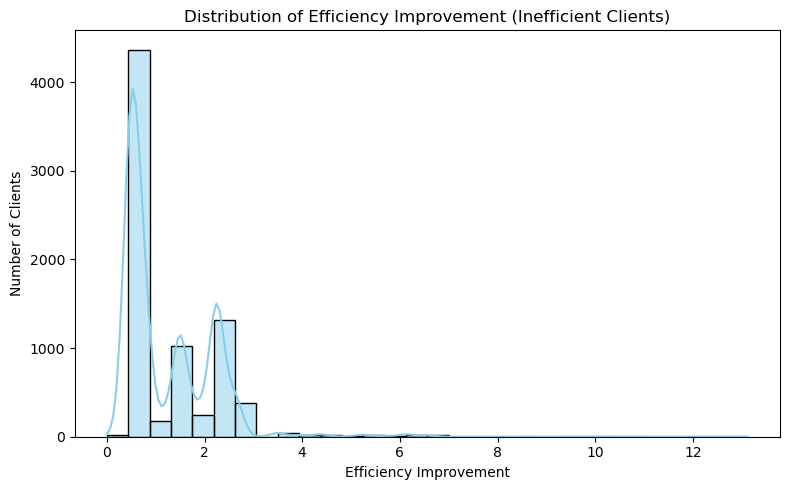

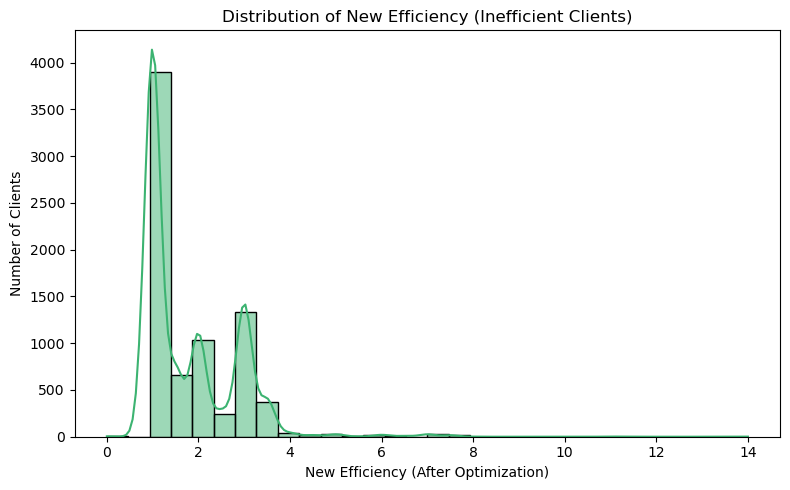

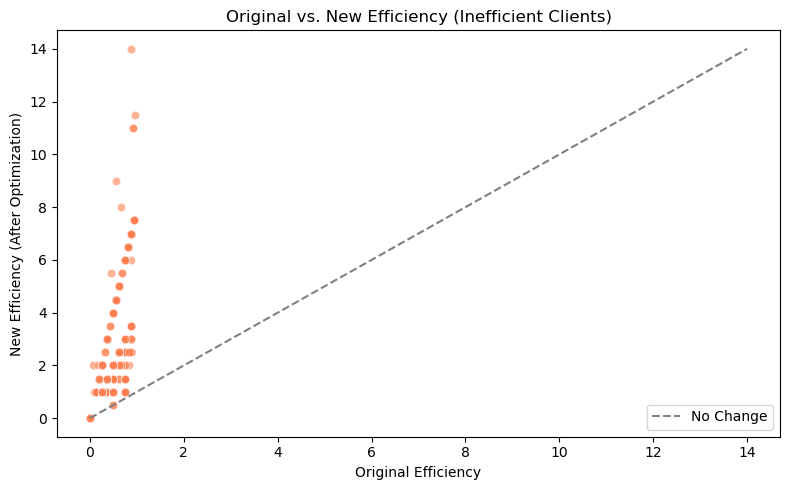

In [12]:
# Display the results for inefficient clients: show key columns and summary statistics

import seaborn as sns
import matplotlib.pyplot as plt

# Show the first 10 inefficient clients with their current and predicted optimal visits and efficiency improvement
display_cols = [
    'client_id', 'efficiency', 'frequency','median_promotor_visits', 'predicted_optimal_visits_per_month',
    'new_efficiency', 'efficiency_improvement'
]
print("Sample of inefficient clients with current number of visits, predicted optimal visits, and efficiency improvement:")
display(inefficient_clients[display_cols].head(10))

# --- Ranking: Top 10 most improved clients ---
print("\nTop 10 inefficient clients with the highest efficiency improvement:")
top_improved = inefficient_clients.sort_values('efficiency_improvement', ascending=False).head(10)
display(top_improved[display_cols])

# --- Visualization 1: Distribution of efficiency improvement ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['efficiency_improvement'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Efficiency Improvement (Inefficient Clients)')
plt.xlabel('Efficiency Improvement')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Visualization 1b: Distribution of new efficiency ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['new_efficiency'], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution of New Efficiency (Inefficient Clients)')
plt.xlabel('New Efficiency (After Optimization)')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Visualization 2: Scatter plot of original vs. new efficiency ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=inefficient_clients,
    x='efficiency',
    y='new_efficiency',
    alpha=0.6,
    color='coral'
)
plt.plot([0, inefficient_clients[['efficiency', 'new_efficiency']].max().max()],
         [0, inefficient_clients[['efficiency', 'new_efficiency']].max().max()],
         ls='--', color='gray', label='No Change')
plt.title('Original vs. New Efficiency (Inefficient Clients)')
plt.xlabel('Original Efficiency')
plt.ylabel('New Efficiency (After Optimization)')
plt.legend()
plt.tight_layout()
plt.show()


### Decision Tree

In [74]:
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
target = "optimal_visits_per_month"

# Split the data into features and target
X = efficient_clients.drop(columns=['client_id', 'promotor_id', 'city', 'channel', target], axis=1)
y = efficient_clients[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data set: ", X_train.shape)
print("Testing data set: ", X_test.shape)

KeyError: "['promotor_id', 'city', 'channel'] not found in axis"

In [72]:
from sklearn.tree import DecisionTreeClassifier

eda_tree = DecisionTreeClassifier(criterion="entropy", random_state=42)
eda_tree.fit(X_train, y_train)

FileNotFoundError: [Errno 2] No such file or directory: '/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/sklearn/utils/_repr_html/estimator.js'

FileNotFoundError: [Errno 2] No such file or directory: '/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.11/site-packages/sklearn/utils/_repr_html/estimator.js'

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
import os
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["CONDA_PREFIX"], "bin")

import graphviz
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_tree(tree, feature_names):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=feature_names,
                    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png("churn_train.png")
    return Image(graph.create_png())

In [ ]:
plot_tree(eda_tree, X_train.columns)

In [ ]:
pred_train = eda_tree.predict(X_train)
print("Accuracy of training set = {0:.2%}".format(accuracy_score(y_train, pred_train)))

pred_test = eda_tree.predict(X_test)
print("Accuracy of testing set = {0:.2%}".format(accuracy_score(y_test, pred_test))

### Stepwise

In [ ]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included